In [1]:
# import libraries
import pandas as pd
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import seaborn as sns;
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
# get the working directory
cwd = os.getcwd()

In [4]:
#load dataset
df = pd.read_csv(os.path.join(cwd, 'montrealbikes.csv'))

In [5]:
df.head()

,Date,Unnamed: 1,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,01/01/2015,00:00,58,12,4,17,33.0,49,21,16,...,NaN,58,91,24,3,NaN,17,78,21,6
1,02/01/2015,00:00,75,7,5,15,30.0,113,27,9,...,NaN,109,177,32,13,NaN,11,57,77,4
2,03/01/2015,00:00,79,7,3,7,30.0,107,36,12,...,NaN,71,131,33,5,NaN,14,174,40,5
3,04/01/2015,00:00,10,1,21,0,10.0,35,29,1,...,NaN,6,11,6,1,NaN,1,20,6,0
4,05/01/2015,00:00,42,0,2,0,27.0,90,21,1,...,NaN,0,5,49,20,NaN,0,41,56,10


In [24]:
df.fillna(0, inplace=True)

In [6]:
df['Unnamed: 1'].unique()

array(['00:00'], dtype=object)

In [7]:
# remove columns Unnamed: 1 since it doesn't have any valuable information
df.drop('Unnamed: 1', axis = 1, inplace = True)

In [9]:
cols_lanes = df.columns[1:]
print(cols_lanes)

Index(['Berri1', 'Boyer', 'Brébeuf', 'CSC (Côte Sainte-Catherine)',
       'Maisonneuve_1', 'Maisonneuve_2', 'Maisonneuve_3', 'Notre-Dame', 'Parc',
       'Parc U-Zelt Test', 'PierDup', 'Pont_Jacques_Cartier',
       'Rachel / Hôtel de Ville', 'Rachel / Papineau', 'René-Lévesque',
       'Saint-Antoine', 'Saint-Laurent U-Zelt Test', 'Saint-Urbain',
       'Totem_Laurier', 'University', 'Viger'],
      dtype='object')


These rows correspond to days of the year 2015 and the columns are the bike lanes in Montreal. The numbers in the cells are the number of bikes that used that lane.

### EDA

In [10]:
df.describe()

,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,Parc U-Zelt Test,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
count,319.000000,319.000000,319.000000,319.000000,62.000000,319.000000,319.000000,319.000000,319.000000,52.000000,...,209.000000,319.000000,319.000000,319.000000,319.000000,50.000000,319.000000,319.000000,319.000000,319.000000
mean,2915.398119,2212.909091,2859.485893,1167.388715,89.935484,2208.031348,1011.175549,1137.316614,1754.257053,2090.250000,...,2164.578947,2207.626959,2939.294671,1477.206897,207.476489,4563.180000,1387.119122,1903.363636,2023.708464,295.347962
std,2276.281648,1832.808709,2337.531344,960.020397,51.886974,2452.475658,917.450049,991.065590,1415.004315,972.740577,...,1049.224968,1660.936427,2105.774880,1254.990855,231.009131,1667.554469,1070.781272,1376.375755,1632.368428,248.947624
min,10.000000,0.000000,0.000000,0.000000,10.000000,2.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,5.000000,0.000000,0.000000,1554.000000,0.000000,20.000000,6.000000,0.000000
25%,387.500000,3.500000,33.000000,54.500000,46.500000,214.500000,119.000000,25.500000,61.000000,1275.000000,...,1221.000000,324.500000,513.000000,159.500000,15.500000,3097.250000,244.500000,457.000000,352.500000,47.000000
50%,3044.000000,2180.000000,3011.000000,1162.000000,85.000000,689.000000,1049.000000,1067.000000,1787.000000,2258.000000,...,2349.000000,2361.000000,3169.000000,1422.000000,107.000000,4825.500000,1519.000000,1855.000000,1762.000000,267.000000
75%,4968.000000,3937.000000,5088.000000,1948.000000,131.500000,4114.500000,1675.000000,2094.500000,3025.500000,2775.500000,...,2966.000000,3658.000000,4797.000000,2676.000000,337.000000,5957.750000,2237.000000,3111.000000,3539.000000,526.000000
max,7387.000000,6153.000000,7322.000000,3334.000000,207.000000,7905.000000,9999.000000,3035.000000,4867.000000,3997.000000,...,6014.000000,7921.000000,7695.000000,4118.000000,781.000000,7388.000000,4342.000000,5166.000000,5596.000000,820.000000


In [11]:
print(len(df.columns))

22


There is 1 column with Date and 21 columns where each column corresponds to a bike lane in Montreal

In [12]:
# change format to datetime
df['Date_dt'] = pd.to_datetime(df.Date, format='%d/%m/%Y')

In [13]:
# sort df in ascending order
df = df.sort_values(by = 'Date_dt')

In [14]:
# Extract month, day, day of the week from Date
df['day'] = df.Date_dt.dt.day
df['month'] = df.Date_dt.dt.month
df['dow'] = df.Date_dt.dt.day_of_week

In [25]:
# get total number of bikes per day and add to df
val=[]
for i in range(len(df)):
    val.append(df[cols_lanes].iloc[i,:].values.sum())
    
df['total_bikes'] = val

In [26]:
df[cols_lanes]

,Berri1,Boyer,Brébeuf,CSC (Côte Sainte-Catherine),Maisonneuve_1,Maisonneuve_2,Maisonneuve_3,Notre-Dame,Parc,Parc U-Zelt Test,...,Pont_Jacques_Cartier,Rachel / Hôtel de Ville,Rachel / Papineau,René-Lévesque,Saint-Antoine,Saint-Laurent U-Zelt Test,Saint-Urbain,Totem_Laurier,University,Viger
0,58,12,4,17,33.0,49,21,16,16,0.0,...,0.0,58,91,24,3,0.0,17,78,21,6
1,75,7,5,15,30.0,113,27,9,32,0.0,...,0.0,109,177,32,13,0.0,11,57,77,4
2,79,7,3,7,30.0,107,36,12,18,0.0,...,0.0,71,131,33,5,0.0,14,174,40,5
3,10,1,21,0,10.0,35,29,1,0,0.0,...,0.0,6,11,6,1,0.0,1,20,6,0
4,42,0,2,0,27.0,90,21,1,1,0.0,...,0.0,0,5,49,20,0.0,0,41,56,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,3044,1931,2828,1393,0.0,3603,1754,1142,2342,3997.0,...,950.0,2328,3280,1210,338,4065.0,1534,1527,2860,356
315,1751,930,1670,888,0.0,2048,700,675,1566,2945.0,...,467.0,1345,1877,755,180,2336.0,960,955,1777,198
316,1818,906,1711,873,0.0,2115,634,477,1522,1693.0,...,482.0,1416,1980,719,204,2628.0,978,1040,1727,258
317,979,759,978,322,0.0,1112,290,310,601,604.0,...,266.0,1061,1448,269,70,1876.0,640,805,737,73


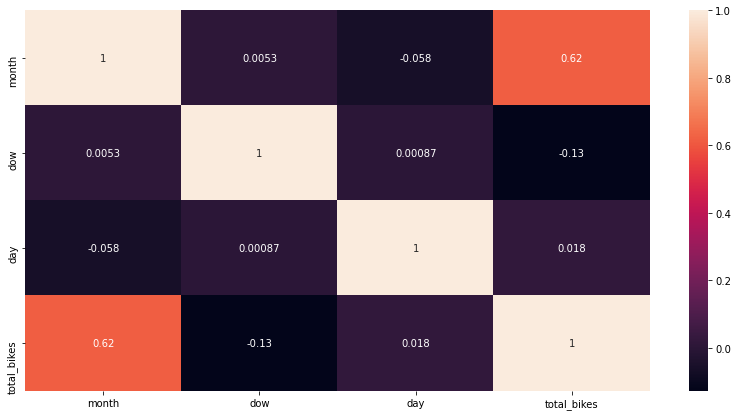

In [27]:
# correlation between month, day of week and the number of bokes
data_corr=df[["month","dow","day","total_bikes"]]
plt.figure(figsize=(14,7))
sns.heatmap(data_corr.corr(),annot=True)
plt.show()